In [7]:
! pip install gpxpy

# Librerías generales y para manejo de datos
import requests # Para hacer solicitudes HTTP a las APIs
import math # Para operaciones matemáticas, como cálculos trigonométricos (Haversine)
import numpy as np # Para manejo eficiente de arrays numéricos (suavizado de elevación)

# Librerías para análisis y manejo de archivos GPX
import gpxpy # Para leer y escribir archivos GPX
import gpxpy.gpx # Módulo específico de gpxpy para objetos GPX

# Librerías para visualización
import matplotlib.pyplot as plt # Para graficar el perfil de elevación
import folium # Para crear mapas interactivos de la ruta

# 🌍 Route Planner – Flujo de trabajo

Este notebook construye un planificador de rutas que permite:
1. Buscar un lugar por su nombre.
2. Calcular distancias entre puntos a pie, bicicleta o carro.
3. Obtener información de elevación para conocer el perfil de la ruta.
4. Visualizar la ruta en un mapa interactivo.
5. Exportar la ruta en formato GPX para usarla en aplicaciones deportivas (Strava, Garmin, etc.).
6. Generar rutas circulares (loop) según la distancia o tiempo deseado.

---

## 🔄 Flujo de trabajo paso a paso

### 1. Geocodificación con Nominatim
- Convierte el nombre de un lugar (ejemplo: *Plaza de Bolivar, Bogotá*) en coordenadas **latitud/longitud**.
- Se usa la API de **Nominatim (OpenStreetMap)** para esta tarea.

### 2. Cálculo de distancias con OSRM
- Se consulta la API de **OSRM (Open Source Routing Machine)** para calcular distancias entre dos puntos.
- Permite elegir el modo de transporte: caminar (`foot`) o bicicleta (`bike`)

### 3. Elevación con Open-Elevation
- Se obtiene la altitud de cada punto de la ruta usando la API **Open-Elevation**.
- Esto permite construir un **perfil de elevación** para ver subidas y bajadas.

#### 3b. Suavizado de elevación
- Se aplica un suavizado matemático para evitar picos bruscos en el perfil.
- El objetivo es que el gráfico sea más realista y legible.

#### 3c. Gráfica del perfil
- Se utiliza **Matplotlib** para graficar el perfil de elevación.
- El resultado es una curva que muestra cómo cambia la altitud a lo largo de la ruta.

#### 3d. Guardar GPX
- La ruta final se guarda en un archivo **GPX** usando la librería `gpxpy`.
- Este archivo puede cargarse en apps como **Strava, Garmin o Komoot**.

### 4. Direcciones cardinales
- Se implementa una utilidad para orientar la ruta en direcciones (N, S, W, E).

### 5. Generar ruta circular (Loop)
- El sistema permite crear rutas circulares según una distancia o tiempo objetivo.
- Ideal para entrenamientos: se parte y termina en el mismo lugar.

---

## 🛠️ Herramientas y APIs utilizadas

- **requests** → Para hacer solicitudes HTTP a las APIs.
- **math** y **numpy** → Para cálculos matemáticos y suavizado de datos.
- **gpxpy** → Lectura y escritura de archivos GPX.
- **matplotlib** → Gráficos del perfil de elevación.
- **folium** → Mapas interactivos de la ruta.

### 🌐 APIs externas
- **Nominatim (OpenStreetMap)** → Convierte nombres de lugares a coordenadas geográficas.
- **OSRM (Open Source Routing Machine)** → Calcula rutas y distancias según el modo de transporte.
- **Open-Elevation API** → Proporciona datos de elevación para cada punto de la ruta.




In [8]:
# ==========================
# 1. Geocodificación con Nominatim
# ==========================
def geocode_place(place_name):
    """
    Convierte un nombre de lugar en lat/lon usando Nominatim (OSM).

    API utilizada: Nominatim (OpenStreetMap)
    Propósito: Convertir nombres de lugares a coordenadas geográficas (latitud y longitud).

    Args:
        place_name (str): Nombre del lugar a geocodificar.

    Returns:
        tuple: Una tupla con la latitud y longitud del lugar (lat, lon).

    Raises:
        ValueError: Si no se encuentra ubicación para el nombre del lugar proporcionado.
    """
    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": place_name, "format": "json", "limit": 1}
    headers = {"User-Agent": "StravaTrainingApp/1.0"}
    resp = requests.get(url, params=params, headers=headers)
    data = resp.json()
    if len(data) == 0:
        raise ValueError(f"No se encontró ubicación para: {place_name}")
    lat = float(data[0]["lat"])
    lon = float(data[0]["lon"])
    print(f"📍 Lugar encontrado: {place_name} → lat={lat}, lon={lon}")
    return lat, lon

# ==========================
# 2. Distancia con OSRM
# ==========================
def get_route_distance(start_lat, start_lon, end_lat, end_lon, modo="foot"):
    """
    Consulta OSRM para obtener la distancia en km entre dos puntos.

    API utilizada: OSRM (Open Source Routing Machine)
    Propósito: Calcular la distancia de ruta entre dos puntos geográficos para diferentes modos de transporte.

    Args:
        start_lat (float): Latitud del punto de inicio.
        start_lon (float): Longitud del punto de inicio.
        end_lat (float): Latitud del punto final.
        end_lon (float): Longitud del punto final.
        modo (str, optional): Modo de transporte ('foot', 'bike', 'car', etc.). Por defecto es 'foot'.

    Returns:
        float: Distancia de la ruta en kilómetros.
    """
    url = f"http://router.project-osrm.org/route/v1/{modo}/{start_lon},{start_lat};{end_lon},{end_lat}"
    resp = requests.get(url, params={"overview": "false"})
    data = resp.json()
    dist_km = data["routes"][0]["distance"] / 1000
    return dist_km

# ==========================
# 3. Elevación con Open-Elevation
# ==========================
def get_elevations(coords, batch_size=50):
    """
    Obtiene elevaciones usando Open-Elevation API.

    API utilizada: Open-Elevation API
    Propósito: Obtener la elevación del terreno para una lista de coordenadas geográficas.

    Args:
        coords (list): Lista de coordenadas en formato [lon, lat].
        batch_size (int, optional): Número de puntos por solicitud para la API. Por defecto es 50.

    Returns:
        list: Una lista de elevaciones correspondientes a las coordenadas de entrada.
    """
    elevations = []
    for i in range(0, len(coords), batch_size):
        batch = coords[i:i+batch_size]
        locations = "|".join([f"{lat},{lon}" for lon, lat in batch])
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={locations}"
        resp = requests.get(url)
        data = resp.json()
        if "results" not in data:
            print("⚠️ Error en batch:", data)
            batch_elev = [0] * len(batch)
        else:
            batch_elev = [r["elevation"] for r in data["results"]]
        elevations.extend(batch_elev)
    return elevations

def calc_desnivel(elevations):
    """
    Calcula desnivel positivo acumulado.

    Args:
        elevations (list): Lista de valores de elevación.

    Returns:
        float: Desnivel positivo acumulado en metros.
    """
    return sum(max(0, elevations[i+1] - elevations[i]) for i in range(len(elevations)-1))

# ==========================
# 3b. Suavizado de elevación
# ==========================
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia Haversine entre dos puntos geográficos en kilómetros.

    Args:
        lat1 (float): Latitud del primer punto.
        lon1 (float): Longitud del primer punto.
        lat2 (float): Latitud del segundo punto.
        lon2 (float): Longitud del segundo punto.

    Returns:
        float: Distancia entre los dos puntos en kilómetros.
    """
    R = 6371
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def smooth_elevations_auto(elevations, coords, distancia_km):
    """
    Suaviza las elevaciones usando convolución adaptativa y padding en bordes.
    El parámetro target_smooth_m se ajusta dinámicamente como distancia_km * 150.

    Args:
        elevations (list): Lista de elevaciones sin suavizar.
        coords (list): Lista de coordenadas en formato [lon, lat].
        distancia_km (float): Distancia total de la ruta en kilómetros.

    Returns:
        numpy.ndarray: Un array numpy con las elevaciones suavizadas.
    """
    # Calcular espaciado promedio de los puntos
    dists = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i-1]
        lon2, lat2 = coords[i]
        d = haversine(lat1, lon1, lat2, lon2)
        dists.append(dists[-1] + d)
    total_km = dists[-1]
    n_points = len(coords)
    spacing_m = (total_km * 1000) / n_points

    # Escala dinámica
    target_smooth_m = distancia_km * 15

    window = max(3, int(target_smooth_m / spacing_m))

    # --- Corregir bordes usando padding reflect ---
    pad_width = window // 2
    padded = np.pad(elevations, pad_width, mode="reflect")

    elev_smooth = np.convolve(padded, np.ones(window)/window, mode="same")
    elev_smooth = elev_smooth[pad_width:-pad_width]  # recortar al tamaño original

    return elev_smooth

# ==========================
# 3c. Gráfica de perfil
# ==========================
def plot_elevation_profile(coords, elevations):
    """
    Genera y muestra una gráfica del perfil de elevación de la ruta.

    Args:
        coords (list): Lista de coordenadas en formato [lon, lat].
        elevations (list): Lista de valores de elevación.
    """
    dists = [0]
    for i in range(1, len(coords)):
        lon1, lat1 = coords[i-1]
        lon2, lat2 = coords[i]
        d = haversine(lat1, lon1, lat2, lon2)
        dists.append(dists[-1] + d)
    plt.figure(figsize=(10, 5))
    plt.plot(dists, elevations, color="blue", linewidth=1.5)
    plt.fill_between(dists, elevations, alpha=0.3, color="skyblue")
    plt.title("Perfil de elevación")
    plt.xlabel("Distancia (km)")
    plt.ylabel("Elevación (m)")
    plt.ylim(min(elevations)*0.9, max(elevations)*1.1)
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================
# 3d. Guardar GPX
# ==========================
def save_gpx(coords, elevations, output_file="ruta.gpx"):
    """
    Guarda las coordenadas y elevaciones en un archivo GPX.

    Args:
        coords (list): Lista de coordenadas en formato [lon, lat].
        elevations (list): Lista de valores de elevación.
        output_file (str, optional): Nombre del archivo GPX de salida. Por defecto es "ruta.gpx".

    Returns:
        str: El nombre del archivo GPX guardado.
    """
    gpx = gpxpy.gpx.GPX()
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    for (lon, lat), ele in zip(coords, elevations):
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(lat, lon, elevation=float(ele)))
    with open(output_file, "w") as f:
        f.write(gpx.to_xml())
    print(f"✅ GPX guardado en {output_file} con {len(coords)} puntos")
    return output_file

# ==========================
# 4. Direcciones cardinales
# ==========================
DIRECCIONES = {
    "N":  (1, 0),
    "S":  (-1, 0),
    "E":  (0, 1),
    "W":  (0, -1),
    "NE": (1, 1),
    "NW": (1, -1),
    "SE": (-1, 1),
    "SW": (-1, -1),
}

# ==========================
# 5. Generar ruta circular (solo suavizado)
# ==========================
def generar_ruta_loop(start_lat, start_lon, distancia_km=0, velocidad_kmh=10, tiempo_min=60,
                      modo="foot", direccion="N", max_iter=100):
    """
    Genera una ruta circular aproximada utilizando OSRM para el cálculo de distancias y rutas,
    y Open-Elevation API para obtener las elevaciones.

    APIs utilizadas:
    - Nominatim (OpenStreetMap) (indirectamente a través de geocode_place)
    - OSRM (Open Source Routing Machine)
    - Open-Elevation API

    Propósito: Crear un track GPX y visualizar una ruta circular con desnivel estimado,
               basado en un punto de inicio, distancia o tiempo objetivo, modo de transporte
               y una dirección cardinal aproximada.

    Args:
        start_lat (float): Latitud del punto de inicio.
        start_lon (float): Longitud del punto de inicio.
        distancia_km (float, optional): Distancia objetivo de la ruta en kilómetros. Por defecto es 0 (calculado desde velocidad y tiempo).
        velocidad_kmh (float, optional): Velocidad promedio en km/h para calcular la distancia si distancia_km es 0. Por defecto es 10.
        tiempo_min (int, optional): Tiempo objetivo de la ruta en minutos para calcular la distancia si distancia_km es 0. Por defecto es 60.
        modo (str, optional): Modo de transporte ('foot', 'bike', 'car', etc.) para OSRM. Por defecto es 'foot'.
        direccion (str, optional): Dirección cardinal ('N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW') para determinar la dirección aproximada del loop. Por defecto es 'N'.
        max_iter (int, optional): Número máximo de iteraciones para ajustar el radio de la ruta. Por defecto es 100.

    Returns:
        tuple: Una tupla con:
            - coords (list): Lista de coordenadas [lon, lat] de la ruta.
            - elevations (list): Lista de elevaciones correspondientes a las coordenadas.
            - desnivel (float): Desnivel positivo acumulado estimado en metros.
            - gpx_file (str): Nombre del archivo GPX guardado.
            - m (folium.Map): Objeto del mapa Folium visualizando la ruta.
    """
    if distancia_km == 0:
        distancia_km = velocidad_kmh * tiempo_min / 60

    dx, dy = DIRECCIONES[direccion.upper()]
    radio = distancia_km / 2.0

    for _ in range(max_iter):
        dlat = (dx * radio) / 111.32
        dlon = (dy * radio) / (111.32 * math.cos(math.radians(start_lat)))
        waypoint_lat = start_lat + dlat
        waypoint_lon = start_lon + dlon
        dist_ida = get_route_distance(start_lat, start_lon, waypoint_lat, waypoint_lon, modo)
        dist_vuelta = get_route_distance(waypoint_lat, waypoint_lon, start_lat, start_lon, modo)
        dist_total = dist_ida + dist_vuelta
        error = dist_total - distancia_km
        if abs(error) < distancia_km * 0.1:
            break
        radio *= distancia_km / dist_total

    print(f"🎯 Distancia objetivo: {distancia_km} km")
    print(f"📏 Distancia real: {dist_total:.2f} km (error {error:.2f} km)")

    # Ruta OSRM ida y vuelta
    url_ida = f"http://router.project-osrm.org/route/v1/{modo}/{start_lon},{start_lat};{waypoint_lon},{waypoint_lat}"
    resp_ida = requests.get(url_ida, params={"overview": "full", "geometries": "geojson"})
    coords_ida = resp_ida.json()["routes"][0]["geometry"]["coordinates"]

    url_vuelta = f"http://router.project-osrm.org/route/v1/{modo}/{waypoint_lon},{waypoint_lat};{start_lon},{start_lat}"
    resp_vuelta = requests.get(url_vuelta, params={"overview": "full", "geometries": "geojson"})
    coords_vuelta = resp_vuelta.json()["routes"][0]["geometry"]["coordinates"]

    coords = coords_ida + coords_vuelta

    # Elevaciones suavizadas directamente
    elevations_raw = get_elevations(coords)
    elevations = smooth_elevations_auto(elevations_raw, coords, distancia_km)
    desnivel = calc_desnivel(elevations)
    print(f"⛰️ Desnivel estimado: {desnivel:.0f} m")

    # Guardar GPX
    gpx_file = save_gpx(coords, elevations, f"ruta_loop_{direccion}.gpx")

    # Graficar perfil
    plot_elevation_profile(coords, elevations)

    # Visualizar mapa
    m = folium.Map(location=[start_lat, start_lon], zoom_start=14)
    folium.PolyLine([(lat, lon) for lon, lat in coords], color="blue", weight=4).add_to(m)
    folium.Marker([coords[0][1], coords[0][0]], tooltip="Inicio", icon=folium.Icon(color="green")).add_to(m)
    folium.Marker([coords[-1][1], coords[-1][0]], tooltip="Fin", icon=folium.Icon(color="red")).add_to(m)
    display(m)

    return coords, elevations, desnivel, gpx_file, m

📍 Lugar encontrado: Puente de Guadua, Bogota → lat=4.7263283, lon=-74.1252144
🎯 Distancia objetivo: 100 km
📏 Distancia real: 104.77 km (error 4.77 km)
⛰️ Desnivel estimado: 1918 m
✅ GPX guardado en ruta_loop_NW.gpx con 2545 puntos


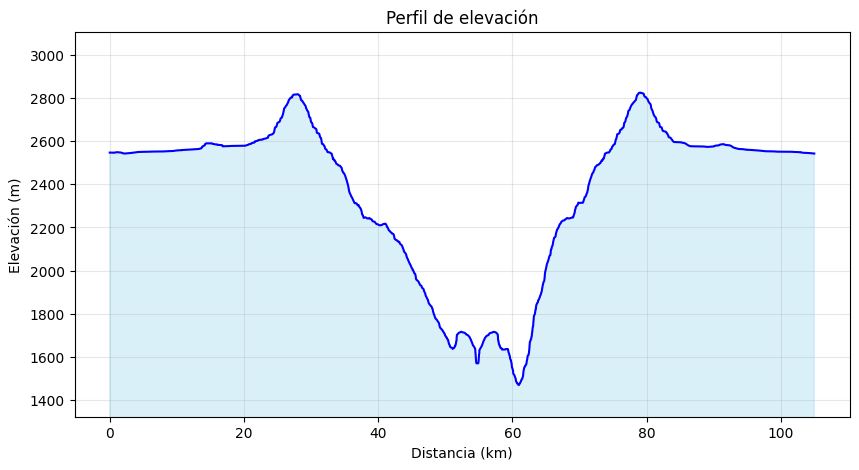

In [9]:
# Buscar coordenadas del lugar
lat, lon = geocode_place("Puente de Guadua, Bogota")

# Generar ruta de 8 km hacia el noreste
coords, elevations, desnivel, gpx_file, mapa = generar_ruta_loop(
    start_lat = lat, start_lon = lon,
    distancia_km = 100,
    modo = "bike",
    direccion = "NW")